# Red neuronal

In [3]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, Adadelta
from keras.regularizers import l2


from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer, MissingIndicator, KNNImputer
from scikeras.wrappers import KerasClassifier
from sklearn import metrics

import numpy as np
import pandas as pd
from preprocessing import *
from matplotlib import pyplot as plt

from joblib import dump, load

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
np.random.seed(123)
tf.random.set_seed(123)

In [5]:
# Para checkear GPU, ignorar
# export LD_LIBRARY_PATH=/usr/local/cuda-11.0/lib64${LD_LIBRARY_PATH:+:${LD_LIBRARY_PATH}}
# for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [6]:
SCORINGS = ["roc_auc", "accuracy", "precision", "recall", "f1"]
METRIC = "roc_auc"

def metrics_table(model, X, Y):
    predicted = model.predict(X)
    probabilities = model.predict_proba(X)[:,1]
    
    roc_auc = metrics.roc_auc_score(Y, probabilities)
    f1 = metrics.f1_score(Y, predicted)
    acc = metrics.accuracy_score(Y, predicted)
    rec = metrics.recall_score(Y, predicted)
    prec = metrics.precision_score(Y, predicted)
    return pd.DataFrame.from_dict({
        "AUC-ROC": [roc_auc], "Accuracy": [acc], "Precision": [prec], "Recall": [rec], "F1 Score": [f1]
    })

def plot_rmse(history):
    loss = np.sqrt(history["loss"])
    val_loss = np.sqrt(history["val_loss"])
    fig = plt.figure(figsize=(12, 6), dpi=80)
    plt.plot(loss, label="Training")
    plt.plot(val_loss, label="Validation")
    plt.legend()
    plt.ylabel("RMSE")
    plt.xlabel("Epoch")

## Modelo inicial (Adam)

Vamos a intentar un modelo inicial con una estructura bastante grande. Los preprocesamientos son el "viento trigonométrico", one-hot encoding, imputación iterativa y estandarización. En todos los modelos vamos a usar activación sigmoidea en la última capa y *binary_crossentropy* como función de pérdida, ya que nos parecen las más convenientes al tener una clasificación binaria. 

In [6]:
df_features, df_target = get_datasets()

viento_trigonometrico(df_features)
df_features = dummy(df_features, ["barrio"])

X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, stratify=df_target.values, test_size=0.35, random_state=123)

pipe = iterative_imputer()
pipe = standarizer(pipe)
len(X_train.columns)

72

In [7]:
pipe.fit(X_train)
X_test_mod = pipe.transform(X_test)
# Aplicamos el preprocesamiento al X de validación asi se lo pasamos a Keras

In [8]:
model = Sequential()
model.add(Dense(100, input_shape = (len(X_train.columns),), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy", tf.keras.metrics.AUC(name = "auc")])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               7300      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 17,501
Trainable params: 17,501
Non-trainable params: 0
_________________________________________________________________


2021-12-08 16:51:58.890623: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-08 16:51:59.729763: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5375 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1


Le ponemos que haga como mucho 3000 epochs, y pare 200 epochs después del mejor AUC-ROC en el set de validación. El parámetro *restore_best_weights* deja al modelo con los mejores pesos obtenidos bajo ese criterio al parar (o sea, con los pesos de la epoch tras la cual pasaron otras 200 más y no mejoró la métrica)

In [9]:
early_stop = EarlyStopping(monitor = "val_auc", mode = "max", patience = 200, restore_best_weights = True)

pipe.steps.append(['keras', KerasClassifier(model, batch_size = 1000, epochs = 3000, callbacks = [early_stop],
                                           verbose = 0)])

In [10]:
pipe.fit(X_train, Y_train, keras__validation_data=(X_test_mod, Y_test))

Pipeline(steps=[('imputer', IterativeImputer(random_state=123)),
                ('scaler', StandardScaler()),
                ['keras',
                 KerasClassifier(batch_size=1000, callbacks=[<keras.callbacks.EarlyStopping object at 0x7fae3c27d5e0>], epochs=3000, model=<keras.engine.sequential.Sequential object at 0x7fae3d9694c0>, verbose=0)]])

In [11]:
history = pipe.named_steps['keras'].history_
print(f"Cantidad de epochs procesadas: {len(history['loss'])}")

Cantidad de epochs procesadas: 237


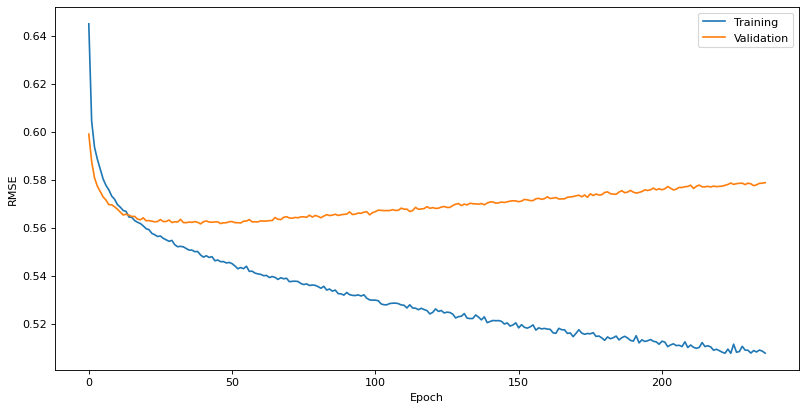

In [12]:
plot_rmse(history)

In [13]:
metrics_table(pipe, X_test, Y_test)

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.898969,0.863927,0.761778,0.570645,0.652502


En el gráfico se puede ver que claramente overfitteo, pero aún así dio valores de AUC-ROC aceptables en las primeras epochs (0.899). 

Para el siguiente modelo, podemos intentar aplicar una regularización, y para simplificar el modelo achicar un poco la arquitectura. También podemos cambiar un poco el preprocesamiento y usar hashing trick en vez de one-hot. El learning rate parece tener un valor correcto a partir del gráfico, ya que no es una curva tan suave pero no tiene picos muy grandes.

## Regularización y Adam

In [30]:
df_features, df_target = get_datasets()

viento_trigonometrico(df_features)
df_features = hashing_trick(df_features, 24, "barrio")

X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, stratify=df_target.values, test_size=0.35, random_state=123)

pipe = iterative_imputer()
pipe = standarizer(pipe)
len(X_train.columns)

47

In [31]:
pipe.fit(X_train)
X_test_mod = pipe.transform(X_test)

In [32]:
model = Sequential()
model.add(Dense(20, input_shape = (len(X_train.columns),), activation='relu', kernel_regularizer=l2(0.00005)))
model.add(Dropout(0.2))
model.add(Dense(10, activation="sigmoid", kernel_regularizer=l2(0.00005)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy", tf.keras.metrics.AUC(name = "auc")])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 20)                960       
                                                                 
 dropout_6 (Dropout)         (None, 20)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                210       
                                                                 
 dropout_7 (Dropout)         (None, 10)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,181
Trainable params: 1,181
Non-trainable params: 0
_________________________________________________________________


In [33]:
early_stop = EarlyStopping(monitor = "val_auc", mode = "max", patience = 200, restore_best_weights = True)

pipe.steps.append(['keras', KerasClassifier(model, batch_size = 1000, epochs = 3000, callbacks = [early_stop],
                                           verbose = 0)])

In [34]:
pipe.fit(X_train, Y_train, keras__validation_data=(X_test_mod, Y_test))

Pipeline(steps=[('imputer', IterativeImputer(random_state=123)),
                ('scaler', StandardScaler()),
                ['keras',
                 KerasClassifier(batch_size=1000, callbacks=[<keras.callbacks.EarlyStopping object at 0x7f6522193670>], epochs=3000, model=<keras.engine.sequential.Sequential object at 0x7f6522193f10>, verbose=0)]])

In [35]:
history = pipe.named_steps['keras'].history_
print(f"Cantidad de epochs procesadas: {len(history['loss'])}")

Cantidad de epochs procesadas: 1320


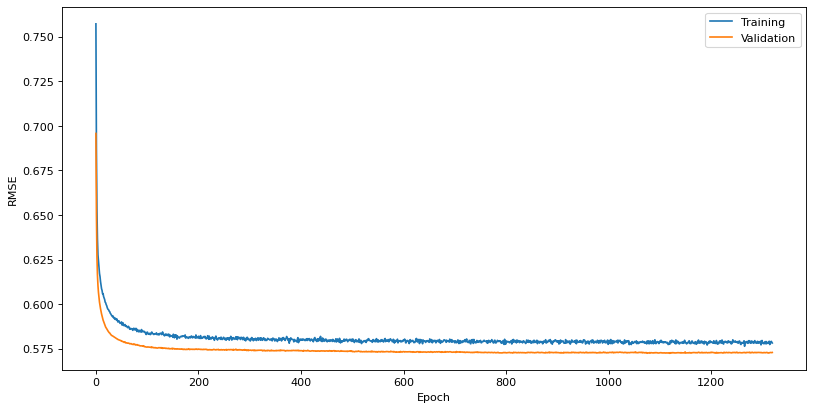

In [36]:
plot_rmse(history)

In [37]:
metrics_table(pipe, X_test, Y_test)

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.893839,0.860214,0.759924,0.549071,0.637515


Overfitteo bastante menos, pero el AUC-ROC empeoró (~0.005). Vamos a probar con otro optimizador

## Regularización y SGD

In [38]:
df_features, df_target = get_datasets()

viento_trigonometrico(df_features)
df_features = hashing_trick(df_features, 24, "barrio")

X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, stratify=df_target.values, test_size=0.35, random_state=123)

pipe = iterative_imputer()
pipe = standarizer(pipe)
len(X_train.columns)

47

In [39]:
pipe.fit(X_train)
X_test_mod = pipe.transform(X_test)

In [40]:
model = Sequential()
model.add(Dense(20, input_shape = (len(X_train.columns),), activation='relu', kernel_regularizer=l2(0.00005)))
model.add(Dropout(0.2))
model.add(Dense(10, activation="sigmoid", kernel_regularizer=l2(0.00005)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
opt = SGD(learning_rate=0.001, momentum = 0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy", tf.keras.metrics.AUC(name = "auc")])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 20)                960       
                                                                 
 dropout_8 (Dropout)         (None, 20)                0         
                                                                 
 dense_13 (Dense)            (None, 10)                210       
                                                                 
 dropout_9 (Dropout)         (None, 10)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,181
Trainable params: 1,181
Non-trainable params: 0
_________________________________________________________________


In [41]:
early_stop = EarlyStopping(monitor = "val_auc", mode = "max", patience = 200, restore_best_weights = True)

pipe.steps.append(['keras', KerasClassifier(model, batch_size = 1000, epochs = 3000, callbacks = [early_stop],
                                           verbose = 0)])

In [42]:
pipe.fit(X_train, Y_train, keras__validation_data=(X_test_mod, Y_test))

Pipeline(steps=[('imputer', IterativeImputer(random_state=123)),
                ('scaler', StandardScaler()),
                ['keras',
                 KerasClassifier(batch_size=1000, callbacks=[<keras.callbacks.EarlyStopping object at 0x7f651c332d30>], epochs=3000, model=<keras.engine.sequential.Sequential object at 0x7f651c34c6d0>, verbose=0)]])

In [43]:
history = pipe.named_steps['keras'].history_
print(f"Cantidad de epochs procesadas: {len(history['loss'])}")

Cantidad de epochs procesadas: 3000


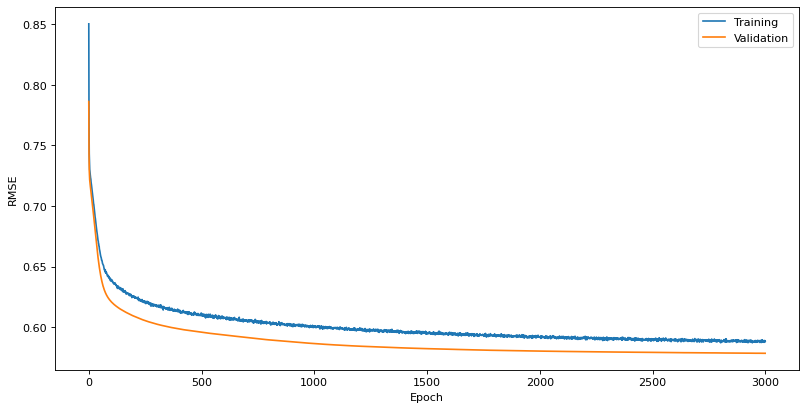

In [44]:
plot_rmse(history)

In [45]:
metrics_table(pipe, X_test, Y_test)

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.887872,0.857394,0.748506,0.546702,0.631882


Dio un poco peor, y tardó bastante más en entrenar, lo que es esperable al ser el optimizador más sencillo. Vamos a probar con otro distinto.

## Regularización y Adadelta

In [46]:
df_features, df_target = get_datasets()

viento_trigonometrico(df_features)
df_features = hashing_trick(df_features, 24, "barrio")

X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, stratify=df_target.values, test_size=0.35, random_state=123)

pipe = iterative_imputer()
pipe = standarizer(pipe)
len(X_train.columns)

47

In [47]:
pipe.fit(X_train)
X_test_mod = pipe.transform(X_test)

In [48]:
model = Sequential()
model.add(Dense(20, input_shape = (len(X_train.columns),), activation='relu', kernel_regularizer=l2(0.00005)))
model.add(Dropout(0.2))
model.add(Dense(10, activation="sigmoid", kernel_regularizer=l2(0.00005)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
opt = Adadelta(learning_rate = 1.0) # Es el inicial, luego se ajusta solo
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy", tf.keras.metrics.AUC(name = "auc")])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 20)                960       
                                                                 
 dropout_10 (Dropout)        (None, 20)                0         
                                                                 
 dense_16 (Dense)            (None, 10)                210       
                                                                 
 dropout_11 (Dropout)        (None, 10)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,181
Trainable params: 1,181
Non-trainable params: 0
_________________________________________________________________


In [49]:
early_stop = EarlyStopping(monitor = "val_auc", mode = "max", patience = 200, restore_best_weights = True)

pipe.steps.append(['keras', KerasClassifier(model, batch_size = 1000, epochs = 3000, callbacks = [early_stop],
                                           verbose = 0)])

In [50]:
pipe.fit(X_train, Y_train, keras__validation_data=(X_test_mod, Y_test))

Pipeline(steps=[('imputer', IterativeImputer(random_state=123)),
                ('scaler', StandardScaler()),
                ['keras',
                 KerasClassifier(batch_size=1000, callbacks=[<keras.callbacks.EarlyStopping object at 0x7f65087894c0>], epochs=3000, model=<keras.engine.sequential.Sequential object at 0x7f6508796340>, verbose=0)]])

In [51]:
history = pipe.named_steps['keras'].history_
print(f"Cantidad de epochs procesadas: {len(history['loss'])}")

Cantidad de epochs procesadas: 1257


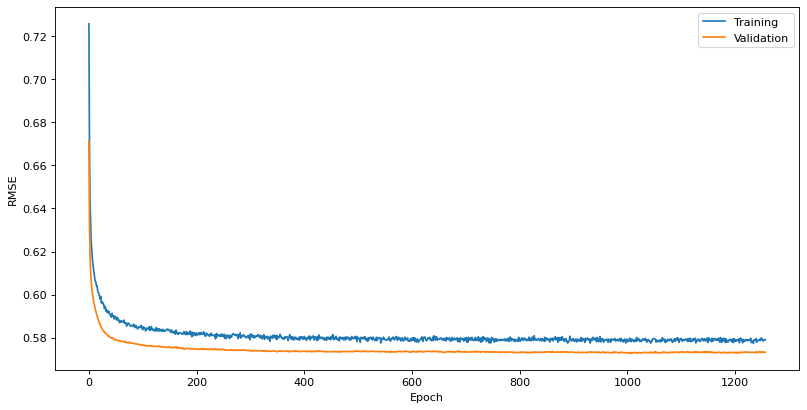

In [52]:
plot_rmse(history)

In [53]:
metrics_table(pipe, X_test, Y_test)

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.893422,0.860381,0.76708,0.540466,0.634136


Este dio bastante mejor comparado al anterior, prácticamente igual que Adam, pero sigue estando por debajo el inicial. Vamos a probar a cambiar un poco más la estructura de la red.

## Regularización y Adadelta v2, más profundo

In [54]:
df_features, df_target = get_datasets()

viento_trigonometrico(df_features)
df_features = hashing_trick(df_features, 24, "barrio")

X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, stratify=df_target.values, test_size=0.35, random_state=123)

pipe = iterative_imputer()
pipe = standarizer(pipe)
len(X_train.columns)

47

In [55]:
pipe.fit(X_train)
X_test_mod = pipe.transform(X_test)

In [56]:
model = Sequential()
model.add(Dense(20, input_shape = (len(X_train.columns),), activation='relu', kernel_regularizer=l2(0.00001)))
model.add(Dropout(0.2))
model.add(Dense(8, input_shape = (len(X_train.columns),), activation='sigmoid', kernel_regularizer=l2(0.00001)))
model.add(Dropout(0.2))
model.add(Dense(8, activation="tanh", kernel_regularizer=l2(0.00005)))
model.add(Dropout(0.2))
model.add(Dense(4, activation="tanh", kernel_regularizer=l2(0.00005)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
opt = Adadelta(learning_rate = 1.0) # Es el inicial, luego se ajusta solo
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy", tf.keras.metrics.AUC(name = "auc")])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 20)                960       
                                                                 
 dropout_12 (Dropout)        (None, 20)                0         
                                                                 
 dense_19 (Dense)            (None, 8)                 168       
                                                                 
 dropout_13 (Dropout)        (None, 8)                 0         
                                                                 
 dense_20 (Dense)            (None, 8)                 72        
                                                                 
 dropout_14 (Dropout)        (None, 8)                 0         
                                                                 
 dense_21 (Dense)            (None, 4)                

In [57]:
early_stop = EarlyStopping(monitor = "val_auc", mode = "max", patience = 200, restore_best_weights = True)

pipe.steps.append(['keras', KerasClassifier(model, batch_size = 1000, epochs = 3000, callbacks = [early_stop],
                                           verbose = 0)])

In [58]:
pipe.fit(X_train, Y_train, keras__validation_data=(X_test_mod, Y_test))

Pipeline(steps=[('imputer', IterativeImputer(random_state=123)),
                ('scaler', StandardScaler()),
                ['keras',
                 KerasClassifier(batch_size=1000, callbacks=[<keras.callbacks.EarlyStopping object at 0x7f651c44efd0>], epochs=3000, model=<keras.engine.sequential.Sequential object at 0x7f65084b0400>, verbose=0)]])

In [59]:
history = pipe.named_steps['keras'].history_
print(f"Cantidad de epochs procesadas: {len(history['loss'])}")

Cantidad de epochs procesadas: 1758


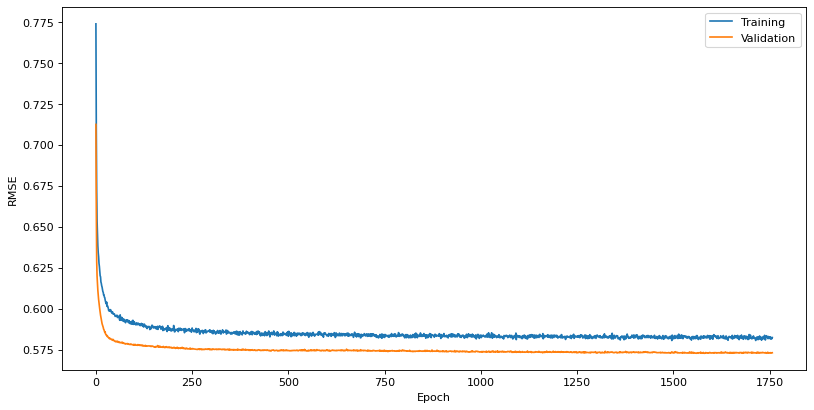

In [60]:
plot_rmse(history)

In [61]:
metrics_table(pipe, X_test, Y_test)

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.893118,0.85812,0.789816,0.499065,0.611646


Dio prácticamente el mismo resultado.

## Grid search

Vamos a terminar probando a hacer un Grid Search con una red sencilla de 2 capas, probando con distintas combinaciones del tamaño de estas capas y sus funciones de activación, y el coeficiente de regularización.

In [23]:
df_features, df_target = get_datasets()

viento_trigonometrico(df_features)
df_features = hashing_trick(df_features, 24, "barrio")

X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, stratify=df_target.values, test_size=0.35, random_state=123)

pipe = iterative_imputer()
pipe = standarizer(pipe)
len(X_train.columns)

47

In [7]:
# Usamos Adadelta
def get_model(cant1, cant2, act1, act2, reg):
    model = Sequential()
    model.add(Dense(cant1, input_shape = (len(X_train.columns),), activation=act1, kernel_regularizer=l2(reg)))
    model.add(Dropout(0.2))
    model.add(Dense(cant2, input_shape = (len(X_train.columns),), activation=act2, kernel_regularizer=l2(reg)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adadelta(learning_rate = 1.0) # Es el inicial, luego se ajusta solo
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy", tf.keras.metrics.AUC(name = "auc")])
    return model

In [12]:
# La grid tarda muchísimo en terminar, si se desea se puede cargar de archivo y saltear el proximo bloque
# de código, descomentando la siguiente línea. También se pueden saltear los próximos 3 bloques de código si
# solo se desea ver el modelo final con los parámetros encontrados.
# grid2 = load('NeuralNetwork/grid.joblib') 

In [8]:
X_grid = pipe.fit_transform(X_train)
early_stop = EarlyStopping(monitor = "auc", mode = "max", patience = 200, restore_best_weights = True)

params = {'model__cant1': [10,20],
          'model__cant2': [8],
          'model__act1': ['relu', 'tanh', 'sigmoid'],
          'model__act2': ['relu', 'tanh', 'sigmoid'],
          'model__reg': [0.00001, 0.0005, 0.01]}

grid = GridSearchCV(KerasClassifier(model = get_model, batch_size = 1000, epochs = 3000, callbacks = [early_stop],
                                    verbose = 0),
                    param_grid = params, verbose = 1, n_jobs = 1, cv = 3, scoring = SCORINGS, refit = METRIC)

grid.fit(X_grid, Y_train.values.ravel())

grid.best_score_

Fitting 3 folds for each of 54 candidates, totalling 162 fits


2021-12-03 01:34:50.964809: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-03 01:34:51.397218: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5375 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1
/home/delu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8903369164927767

In [11]:
dump(grid, 'NeuralNetwork/grid.joblib') 

2021-12-03 09:55:35.710025: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram:///tmp/tmp39p6kdx_/assets


['NeuralNetwork/grid.joblib']

In [12]:
tabla = pd.DataFrame(grid.cv_results_)
tabla.sort_values("rank_test_" + METRIC, inplace = True)
tabla.reset_index(inplace = True)
cols = ["param_" + x for x in params] + ["mean_test_" + x for x in SCORINGS]
tabla[cols]

,param_model__cant1,param_model__cant2,param_model__act1,param_model__act2,param_model__reg,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,20,8,sigmoid,relu,0.00001,0.890337,0.858431,0.772754,0.521118,0.622376
1,20,8,sigmoid,tanh,0.00001,0.890110,0.859544,0.754368,0.552744,0.637881
2,20,8,relu,sigmoid,0.00001,0.889432,0.856958,0.763105,0.523669,0.621083
3,20,8,relu,tanh,0.0005,0.889291,0.857048,0.763855,0.523334,0.621076
4,20,8,tanh,sigmoid,0.00001,0.888929,0.857018,0.776212,0.507756,0.613911
5,20,8,relu,tanh,0.00001,0.888562,0.857469,0.745473,0.551938,0.634191
6,20,8,tanh,relu,0.00001,0.888487,0.856567,0.772898,0.509166,0.613789
7,20,8,tanh,tanh,0.00001,0.888170,0.857169,0.743472,0.552743,0.634055
8,20,8,relu,relu,0.0005,0.888151,0.856522,0.753846,0.534011,0.624671
9,20,8,sigmoid,sigmoid,0.00001,0.887886,0.856688,0.775028,0.507152,0.613065


Entrenamos un modelo con todos los datos de entrenamiento y los mejores parámetros obtenidos

In [25]:
pipe.fit(X_train)
X_test_mod = pipe.transform(X_test)

In [26]:
early_stop = EarlyStopping(monitor = "val_auc", mode = "max", patience = 200, restore_best_weights = True)

pipe.steps.append(['keras', KerasClassifier(get_model(20, 8, 'sigmoid', 'relu', 0.00001), batch_size = 1000, epochs = 3000, callbacks = [early_stop],
                                           verbose = 0)])

In [27]:
pipe.fit(X_train, Y_train, keras__validation_data=(X_test_mod, Y_test))

Pipeline(steps=[('imputer', IterativeImputer(random_state=123)),
                ('scaler', StandardScaler()),
                ['keras',
                 KerasClassifier(batch_size=1000, callbacks=[<keras.callbacks.EarlyStopping object at 0x7f626059aa00>], epochs=3000, model=<keras.engine.sequential.Sequential object at 0x7f626059ae80>, verbose=0)]])

In [24]:
history = pipe.named_steps['keras'].history_
print(f"Cantidad de epochs procesadas: {len(history['loss'])}")

Cantidad de epochs procesadas: 2693


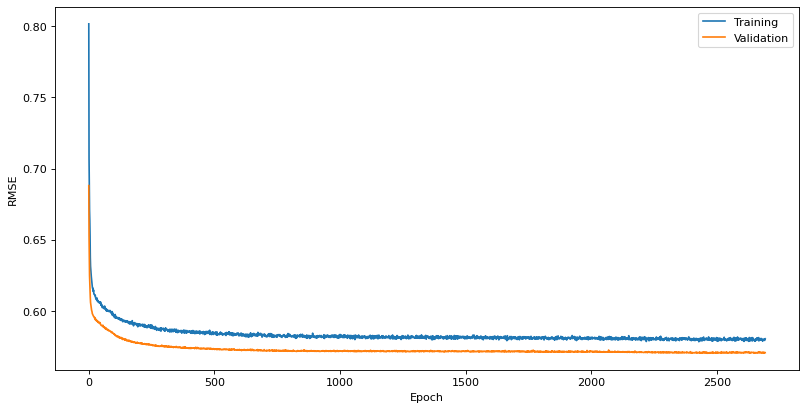

In [25]:
plot_rmse(history)

In [26]:
metrics_table(pipe, X_test, Y_test)

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.894741,0.860074,0.774211,0.529368,0.628796


El AUC dio muy similar a los anteriores (en este caso, ~0.895), un poco peor que el modelo gigantesco inicial pero mejor que los otros regularizados que probamos.

## De nuevo con el procesamiento original

Como el primer modelo resultó ser el de métricas más altas, vamos a probar a hacer un modelo igual al anterior solo que con el preprocesamiento original: One-hot encoding en vez de hashing trick.

In [8]:
df_features, df_target = get_datasets()

viento_trigonometrico(df_features)
df_features = dummy(df_features, ["barrio"])

X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, stratify=df_target.values, test_size=0.35, random_state=123)

pipe = iterative_imputer()
pipe = standarizer(pipe)
len(X_train.columns)

72

In [9]:
pipe.fit(X_train)
X_test_mod = pipe.transform(X_test)

In [10]:
early_stop = EarlyStopping(monitor = "val_auc", mode = "max", patience = 200, restore_best_weights = True)

pipe.steps.append(['keras', KerasClassifier(get_model(20, 8, 'sigmoid', 'relu', 0.00001), batch_size = 1000, epochs = 3000, callbacks = [early_stop],
                                           verbose = 0)])

2021-12-08 17:43:35.327390: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-08 17:43:35.953572: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5375 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1


In [11]:
pipe.fit(X_train, Y_train, keras__validation_data=(X_test_mod, Y_test))


Pipeline(steps=[('imputer', IterativeImputer(random_state=123)),
                ('scaler', StandardScaler()),
                ['keras',
                 KerasClassifier(batch_size=1000, callbacks=[<keras.callbacks.EarlyStopping object at 0x7f6f29e775b0>], epochs=3000, model=<keras.engine.sequential.Sequential object at 0x7f6f29e77580>, verbose=0)]])

In [12]:
history = pipe.named_steps['keras'].history_
print(f"Cantidad de epochs procesadas: {len(history['loss'])}")

Cantidad de epochs procesadas: 1016


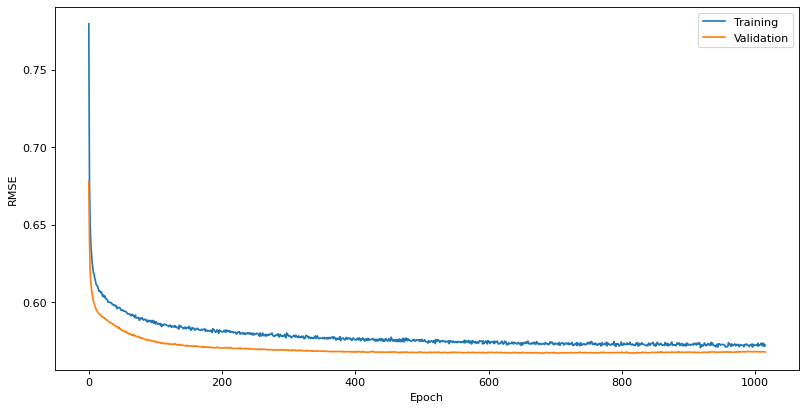

In [13]:
plot_rmse(history)

In [14]:
metrics_table(pipe, X_test, Y_test)

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.896982,0.864597,0.791966,0.535977,0.639298


Dio un poco mejor, ~0.897. Vamos a quedarnos con este modelo antes que el primero ya que es mucho más simple, la arquitectura de la red tiene miles de pesos menos.

## Predicción de nuevos datos

Vamos a utilizar el último modelo obtenido para los datos nuevos pedidos.

In [18]:
initialize_dataset()

df_extra = pd.read_csv("datasets/df_extra.csv", low_memory = False, index_col = "id")

common(df_extra)
viento_trigonometrico(df_extra)
df_extra = dummy(df_extra, ["barrio"])

# El imputer y standarizer ya estan en el pipe

df_extra_predict = pd.DataFrame({"id": df_extra.index, "llovieron_hamburguesas_al_dia_siguiente": pipe.predict(df_extra).flatten()})
df_extra_predict.set_index("id", inplace = True)
df_extra_predict.replace({"llovieron_hamburguesas_al_dia_siguiente": {0.0: "no", 1.0: "si"}}, inplace = True)
df_extra_predict

,llovieron_hamburguesas_al_dia_siguiente
id,
116706,no
58831,no
31981,no
2533,no
7270,si
...,...
73456,no
14471,no
106482,no


In [24]:
df_extra_predict.to_csv("predicciones/NeuralNetwork.csv")

## Predicciones en el holdout

Este resultó ser el mejor modelo de los que pudimos entrenar, asi que vamos a ver sus métricas en el test-holdout.

In [21]:
initialize_dataset()

X_holdout = pd.read_csv("datasets/df_features_holdout.csv", low_memory = False, index_col = "id")
Y_holdout = pd.read_csv("datasets/df_target_holdout.csv", low_memory = False, index_col = "id")

common(X_holdout, Y_holdout)
viento_trigonometrico(X_holdout)
X_holdout = dummy(X_holdout, ["barrio"])

# El imputer y standarizer ya estan en el pipe

metrics_table(pipe, X_holdout, Y_holdout)

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.896491,0.859477,0.781796,0.511637,0.618503


Dio muy similar a lo que nos dio en el set de validación: el AUC-ROC solo bajo alrededor de 0.0005, lo cual es muy positivo.

### Matriz de confusión

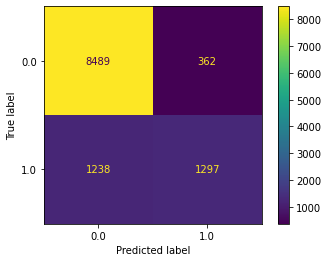

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(Y_holdout, pipe.predict(X_holdout))
None

Podemos ver que lo que el mejor hace el modelo es predecir los negativos. Para el caso de los positivos, se equivoca casi la mitad de las veces, lo que es acorde con el Recall de 0.512 que nos dio. También podemos notar que hay muy pocos falsos positivos.

### Curva ROC

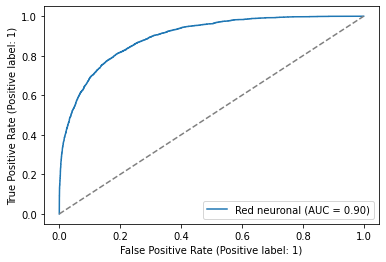

In [23]:
from sklearn.metrics import  RocCurveDisplay
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(Y_holdout, pipe.predict_proba(X_holdout)[:,1], name = "Red neuronal", ax = ax)
ax.plot([0, 1], [0, 1], "--", color="gray")
plt.show()

Podemos ver en la curva que esta bastante por arriba de la recta $y=x$, que sería si el modelo fuera aleatorio. Considerando que esto fue graficado sobre el test-holdout, este modelo parece haber aprendido bastante bien.